# Further investigate which `windowSize` parameters tend to give best `R` when `alpha` fixed at 0.5

In [1]:
library(CpGWAS)

In [2]:
# Want big view for facet plots
options(repr.plot.width=10, repr.plot.height=8)

In [3]:
scaff_paths <- list.files("../output/", pattern = "rds", full.names = TRUE, recursive = FALSE)

extract_info <- function(path) {
  matches <- regmatches(path, regexpr("\\d{8}-\\d{6}", path))
  if (length(matches) > 0) {
    datetime <- strsplit(matches, "-")[[1]]
    date <- paste(substr(datetime[1], 1, 4), substr(datetime[1], 5, 6), substr(datetime[1], 7, 8), sep="-")
    time <- paste(substr(datetime[2], 1, 2), substr(datetime[2], 3, 4), substr(datetime[2], 5, 6), sep=":")
    return(c(date, time))
  } else {
    return(c(NA, NA))
  }
}

data_frame <- do.call(rbind, lapply(scaff_paths, function(path) {
  info <- extract_info(path)
  data.frame(path = path, date = info[1], time = info[2], stringsAsFactors = FALSE)
}))

sorted_data_frame <- data_frame[order(data_frame$date, data_frame$time), ]

In [4]:
scaff_paths <- sorted_data_frame$path

In [5]:
length(scaff_paths)

[1] 50

In [6]:
convertToDataFrame <- function(object) {
  if (!inherits(object, "MethylationScaff")) {
    stop("The object must be of class 'MethylationScaff'.")
  }

  modelsList <- lapply(object@models, function(model) {
    data.frame(
      scaffoldIdentifier = object@scaffoldIdentifier,
      methylationPosition = model@methylationPosition,
      windowSize = model@windowSize,
      nSNPs = model@n_SNPs,
      cor = model@evaluation_results['cor'],
      mse = model@evaluation_results['mse'],
      alpha = model@alpha,
      lambda = model@lambda
    )
  })

  do.call("rbind", modelsList)
}

In [7]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
df <- data.frame()

In [9]:
for(scaff_path in scaff_paths){
    my_scaff <- readRDS(scaff_path)
    small_df <- convertToDataFrame(my_scaff)
    df <- bind_rows(df, small_df)
}

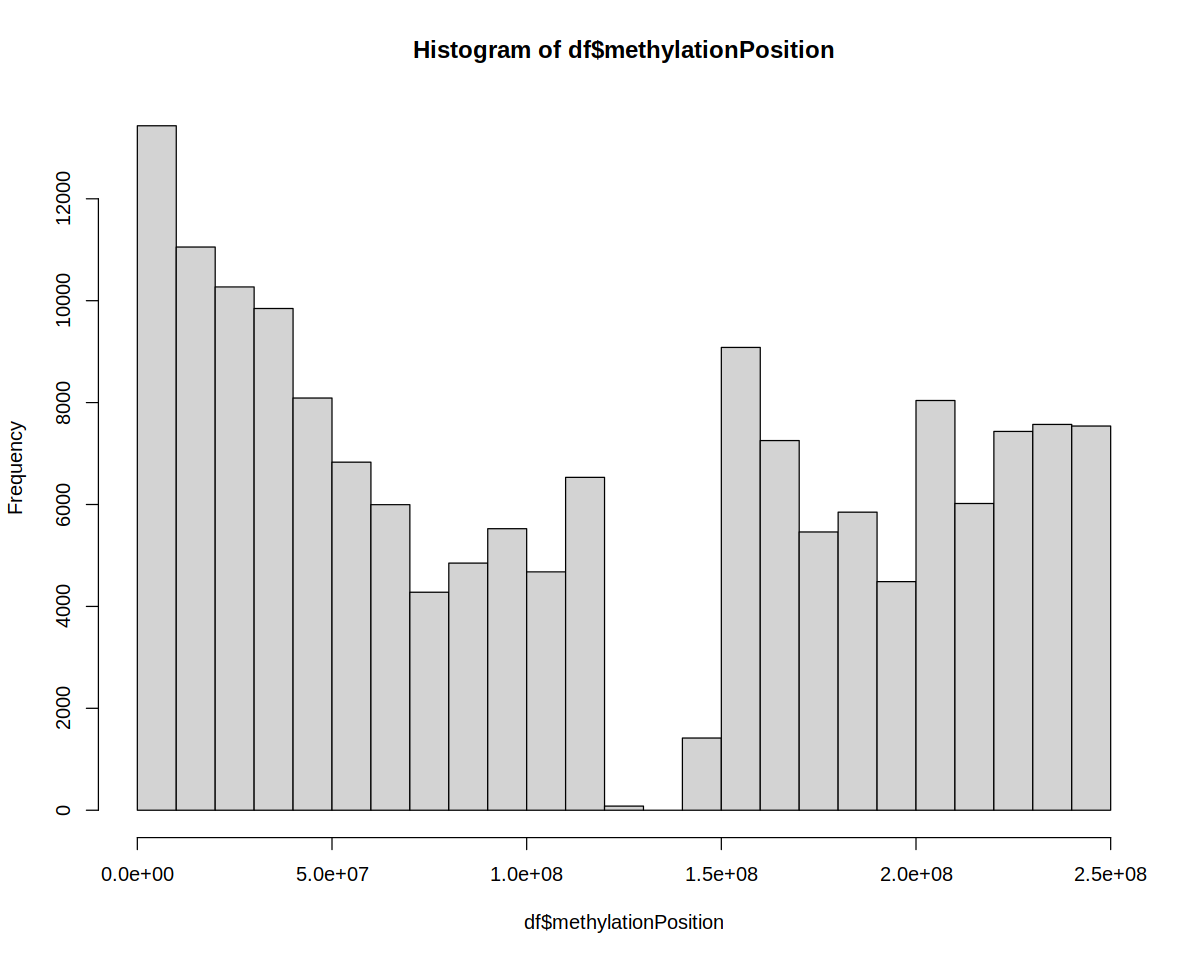

In [10]:
hist(df$methylationPosition)

I'm guessing that's the centromere in the middle

Let's get the first and last SNP positions

In [11]:
start_pos <- min(df$methylationPosition)
end_pos <- max(df$methylationPosition)

In [12]:
start_pos

[1] 795635

In [13]:
end_pos

[1] 248906249

In [14]:
head(levels(factor(df$methylationPosition))) # make sure these don't all end in 0

[1] "795635" "832079" "834506" "844858" "901841" "903189"

What percentage of models have all coefficients dropped during regularization?

In [15]:
sum(is.na(df$cor))/dim(df)[1]

[1] 0.04716473

In [16]:
coverage_summary <- as.data.frame(table(df$windowSize))

In [17]:
head(coverage_summary)

,Var1,Freq
,<fct>,<int>
1,2000,8737
2,4000,9223
3,6000,9313
4,8000,9351
5,10000,9371
6,20000,9436


In [18]:
colnames(coverage_summary) <- c("windowSize", "percentage_sites_covered")
coverage_summary$percentage_sites_covered <- 
(coverage_summary$percentage_sites_covered / 10000) * 100

In [19]:
dim(coverage_summary)

[1] 17  2

What percentage of methylation sites have SNPs within defined window of each given size?

In [20]:
coverage_summary$percentage_sites_uncovered <- 100 - coverage_summary$percentage_sites_covered

In [21]:
coverage_summary

windowSize,percentage_sites_covered,percentage_sites_uncovered
<fct>,<dbl>,<dbl>
2000,87.37,12.63
4000,92.23,7.77
6000,93.13,6.87
8000,93.51,6.49
10000,93.71,6.29
20000,94.36,5.64
40000,95.23,4.77
50000,95.48,4.52
60000,95.61,4.39


<div class="alert alert-block alert-info">Note trend. 93.4% coverage for 10kb window vs. 97.7% coverage for 500kb window </div>

## Which `window_size`s tend to give most `NA` for `R` value?

We get `NA` values for `R` when all SNPs are dropped during regularization.

In [22]:
head(df)

,scaffoldIdentifier,methylationPosition,windowSize,nSNPs,cor,mse,alpha,lambda
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
cor...1,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,2000,14,0.4206647,0.0007567610,0.5,0.01448255
cor1...2,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,4000,20,0.4141016,0.0007581992,0.5,0.01744429
cor2...3,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,6000,26,0.4538260,0.0007615585,0.5,0.01448255
cor3...4,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,8000,35,0.4476455,0.0007698359,0.5,0.01744429
cor4...5,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,10000,53,0.3657557,0.0007901104,0.5,0.01448255
cor5...6,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,20000,115,0.4557985,0.0007444746,0.5,0.01202367


In [23]:
library(dplyr)
library(ggplot2)

na_percentage.2 <- df %>%
  mutate(alpha = factor(alpha, labels = paste("alpha =", levels(factor(alpha)))),
         windowSize = factor(windowSize, labels = levels(factor(windowSize)))) %>%
  group_by(alpha, windowSize) %>%
  summarise(PercentageNA = mean(is.na(cor)) * 100, .groups = 'drop')

na_count <- df %>%
  mutate(alpha = factor(alpha, labels = paste("alpha =", levels(factor(alpha)))),
         windowSize = factor(windowSize, labels = levels(factor(windowSize)))) %>%
  group_by(alpha, windowSize) %>%
  summarise(CountNA = sum(is.na(cor)), .groups = 'drop')

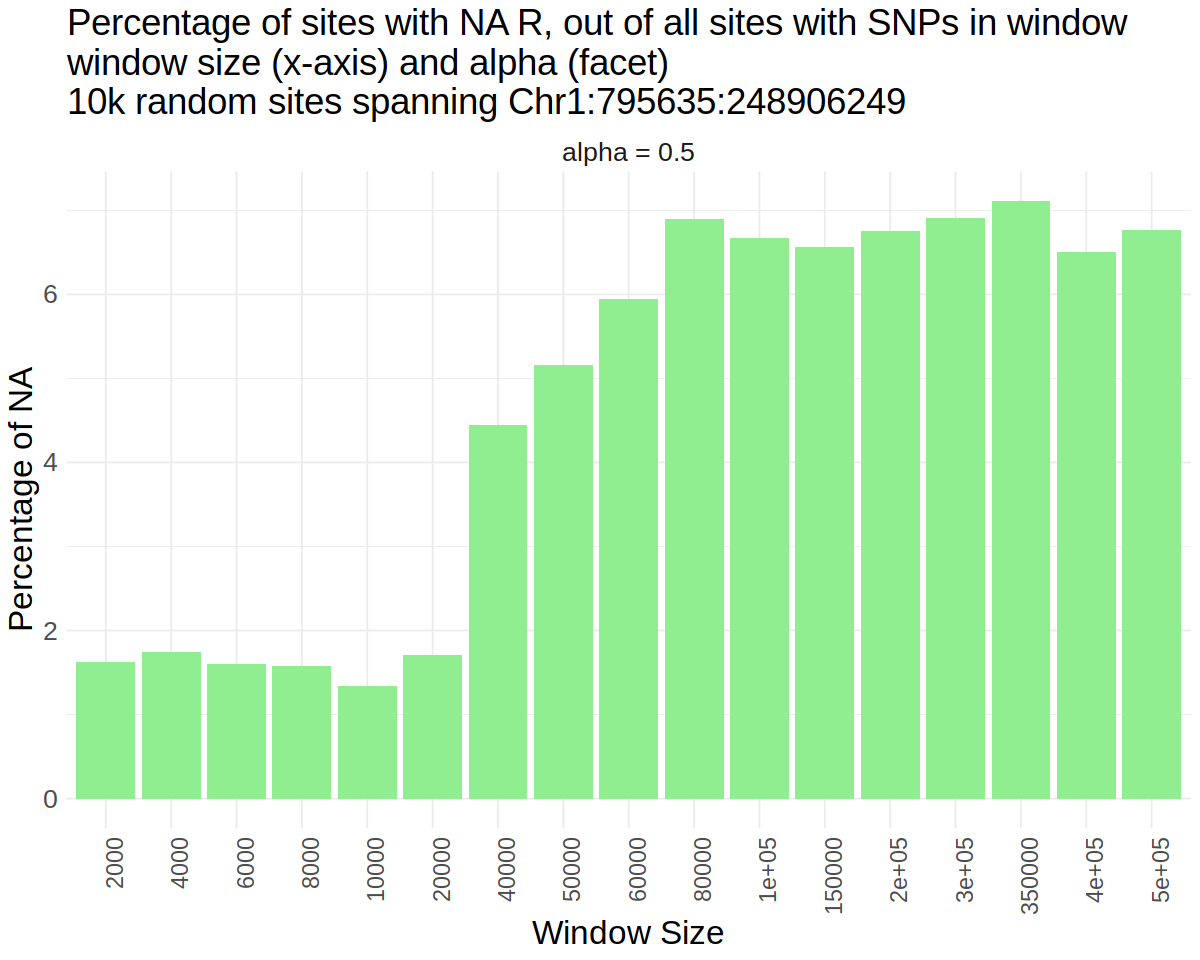

In [24]:
ggplot(na_percentage.2, aes(x = as.factor(windowSize), y = PercentageNA)) +
  geom_bar(stat = "identity", fill = "lightgreen") +
  #geom_text(aes(label = sprintf("%.2f%%", PercentageNA)), vjust = -1, hjust = 0.5, angle = 45) +
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("Percentage of sites with NA R, out of all sites with SNPs in window\nwindow size (x-axis) and alpha (facet)\n10k random sites spanning Chr1:",
                      start_pos, ":", end_pos), x = "Window Size", y = "Percentage of NA") +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 14)
  )

<div class="alert alert-block alert-info">Keep in mind, the stats in the plot are for the percentage of sites for which we DO have SNPs within given window. </div>

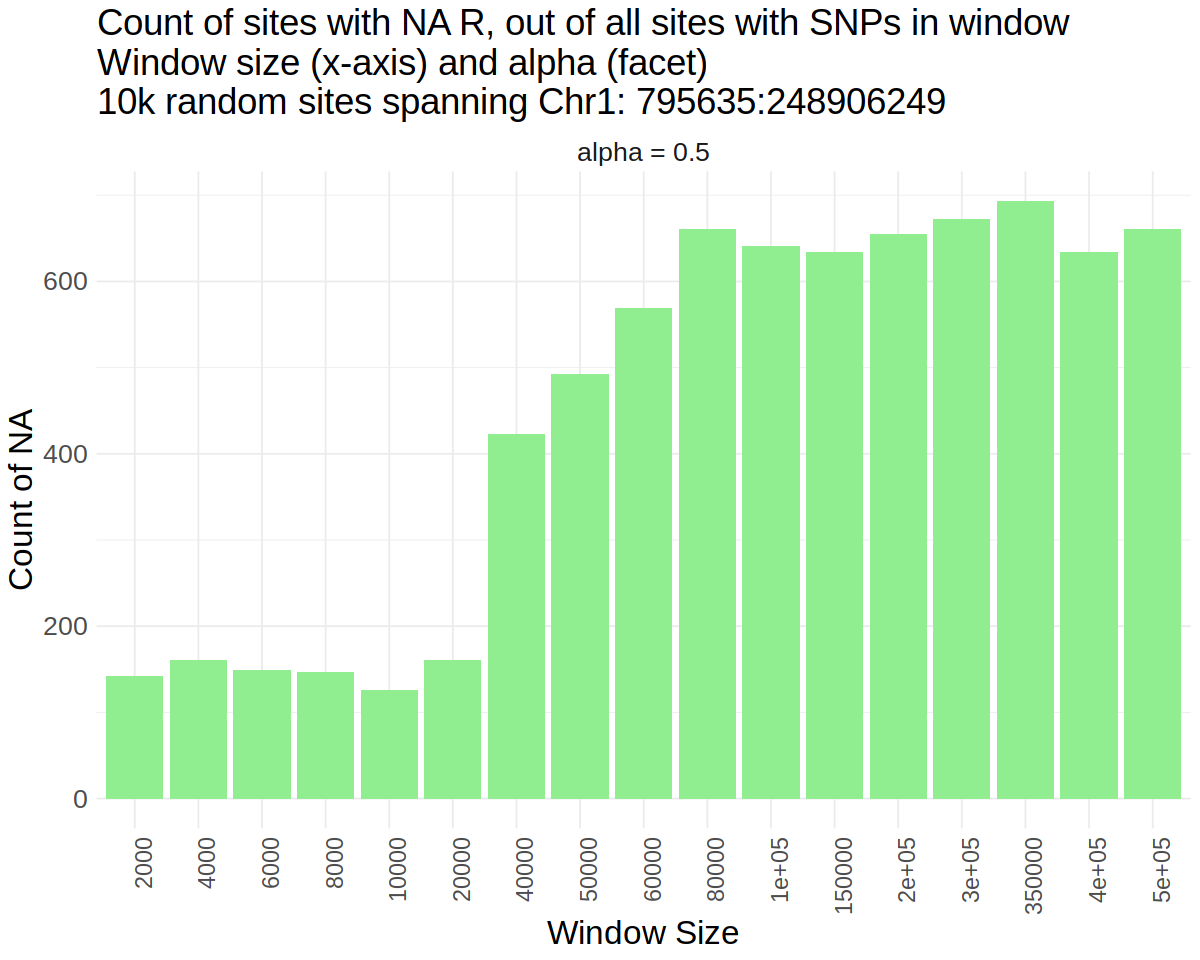

In [25]:
ggplot(na_count, aes(x = as.factor(windowSize), y = CountNA)) +
  geom_bar(stat = "identity", fill = "lightgreen") +
  # If you want to add text labels showing counts uncomment the line below
  #geom_text(aes(label = CountNA), vjust = -1, hjust = 0.5, angle = 45) +
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("Count of sites with NA R, out of all sites with SNPs in window\nWindow size (x-axis) and alpha (facet)\n10k random sites spanning Chr1: ", start_pos, ":", end_pos),
       x = "Window Size", y = "Count of NA") +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 14)
  )

In [26]:
head(df)

,scaffoldIdentifier,methylationPosition,windowSize,nSNPs,cor,mse,alpha,lambda
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
cor...1,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,2000,14,0.4206647,0.0007567610,0.5,0.01448255
cor1...2,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,4000,20,0.4141016,0.0007581992,0.5,0.01744429
cor2...3,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,6000,26,0.4538260,0.0007615585,0.5,0.01448255
cor3...4,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,8000,35,0.4476455,0.0007698359,0.5,0.01744429
cor4...5,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,10000,53,0.3657557,0.0007901104,0.5,0.01448255
cor5...6,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,20000,115,0.4557985,0.0007444746,0.5,0.01202367


In [27]:
dim(df)

[1] 161625      8

In [28]:
length(levels(factor(df$windowSize)))

[1] 17

In [29]:
length(levels(factor(df$alpha)))

[1] 1

In [30]:
17*9769

[1] 166073

In [31]:
length(levels(factor(df$methylationPosition)))

[1] 9769

In [32]:
# Aggregate to count NA values directly
na_count <- aggregate(is.na(cor) ~ alpha + windowSize, data = df, FUN = sum)

# Aggregate to count total rows for each alpha and windowSize combination
total_rows <- aggregate(rep(1, nrow(df)) ~ alpha + windowSize, data = df, FUN = sum)

# Merge the aggregated NA counts and total row counts
agg_data <- merge(na_count, total_rows, by = c("alpha", "windowSize"))

# Rename columns for clarity
names(agg_data) <- c("alpha", "windowSize", "CountNA", "TotalRows")

# Calculate the percentage of NA values
agg_data$PercentageNA <- (agg_data$CountNA / agg_data$TotalRows) * 100

# Display the aggregated data frame
agg_data


alpha,windowSize,CountNA,TotalRows,PercentageNA
<dbl>,<dbl>,<int>,<dbl>,<dbl>
0.5,10000,126,9371,1.344574
0.5,150000,634,9652,6.568587
0.5,100000,641,9614,6.667360
0.5,2000,142,8737,1.625272
0.5,20000,161,9436,1.706231
0.5,200000,655,9699,6.753274
0.5,350000,693,9749,7.108421
0.5,300000,673,9733,6.914620
0.5,4000,161,9223,1.745636


In [33]:
head(coverage_summary)

,windowSize,percentage_sites_covered,percentage_sites_uncovered
,<fct>,<dbl>,<dbl>
1,2000,87.37,12.63
2,4000,92.23,7.77
3,6000,93.13,6.87
4,8000,93.51,6.49
5,10000,93.71,6.29
6,20000,94.36,5.64


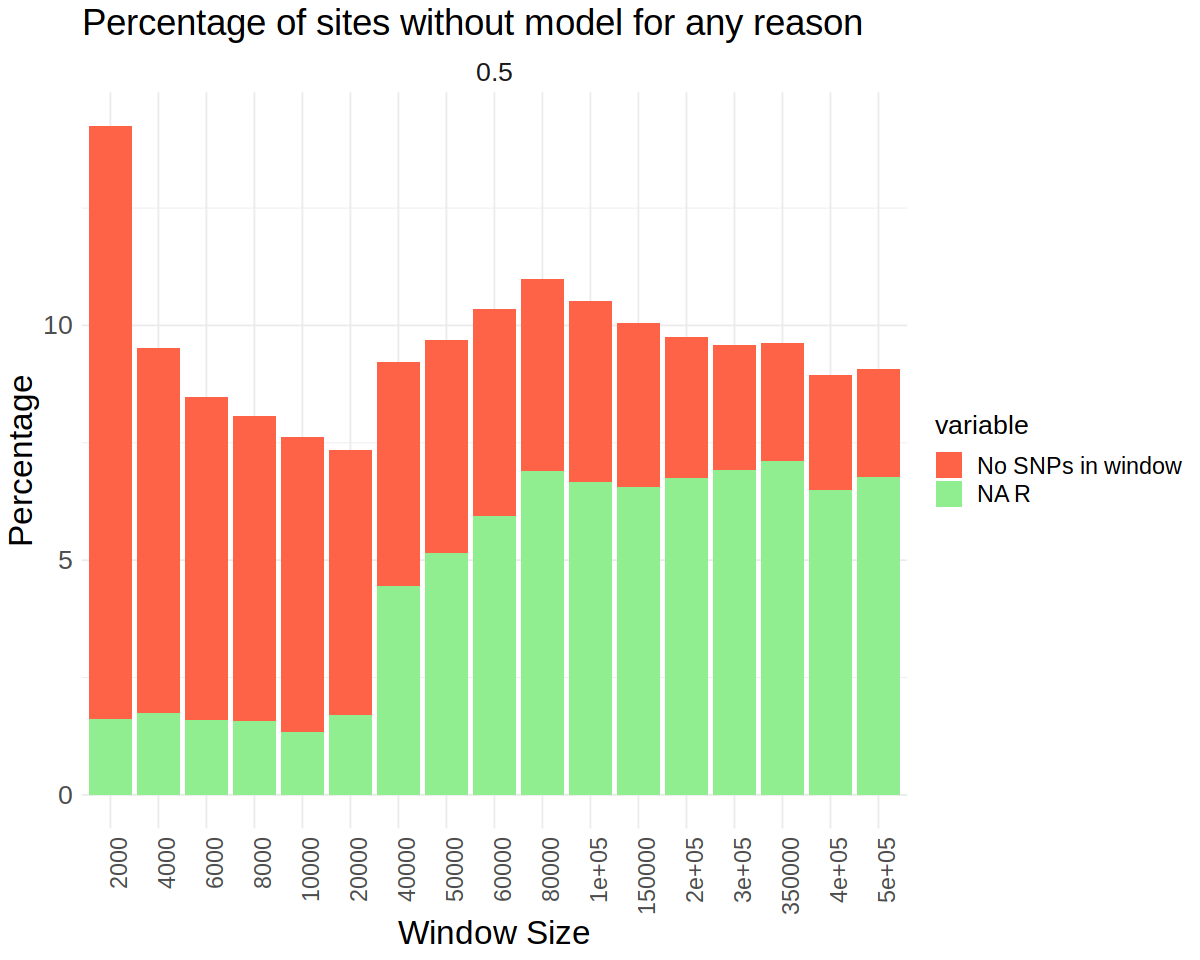

In [34]:
merged <- merge(coverage_summary, agg_data)

library(ggplot2)
library(reshape2)

# Assuming 'merged' is your data.frame
# Reshape the data to long format
merged_melted <- melt(merged, id.vars = c("windowSize", "alpha"), measure.vars = c("percentage_sites_uncovered", "PercentageNA"))

# Rename the variable and value
merged_melted$variable <- factor(merged_melted$variable, levels = c("percentage_sites_uncovered", "PercentageNA"),
                                  labels = c("No SNPs in window", "NA R"))

# Now plot
ggplot(merged_melted, aes(x = as.factor(windowSize), y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  labs(title = "Percentage of sites without model for any reason", 
       x = "Window Size", 
       y = "Percentage") +
  facet_wrap(~alpha) +
  theme_minimal() +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  ) +
  scale_fill_manual(values = c("No SNPs in window" = "tomato", "NA R" = "lightgreen"))

## See which have best `alpha`, `window_size` tend to give best R (`cor`)

Warning message:
“Removed 7623 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 7623 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 7623 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 7623 rows containing missing values (`geom_point()`).”


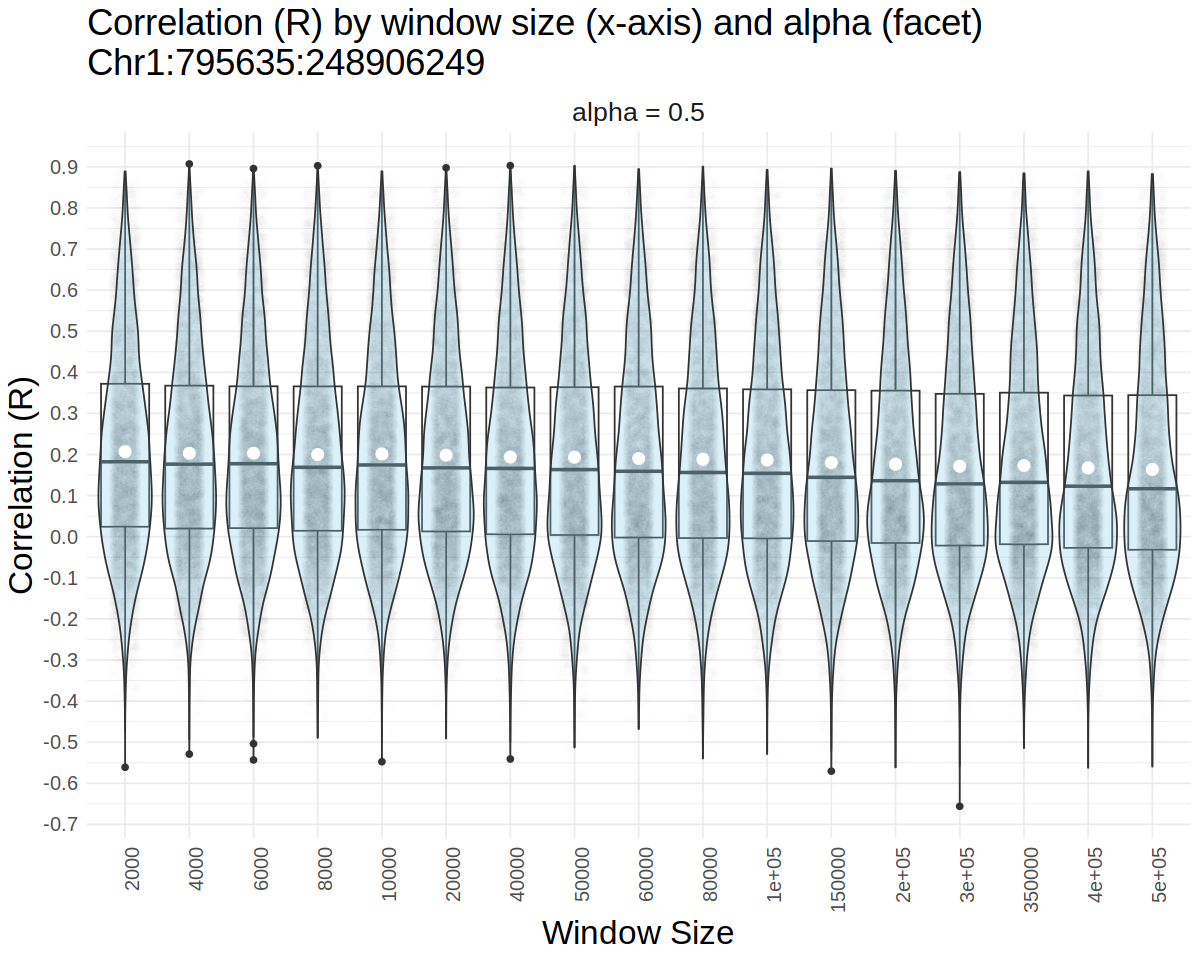

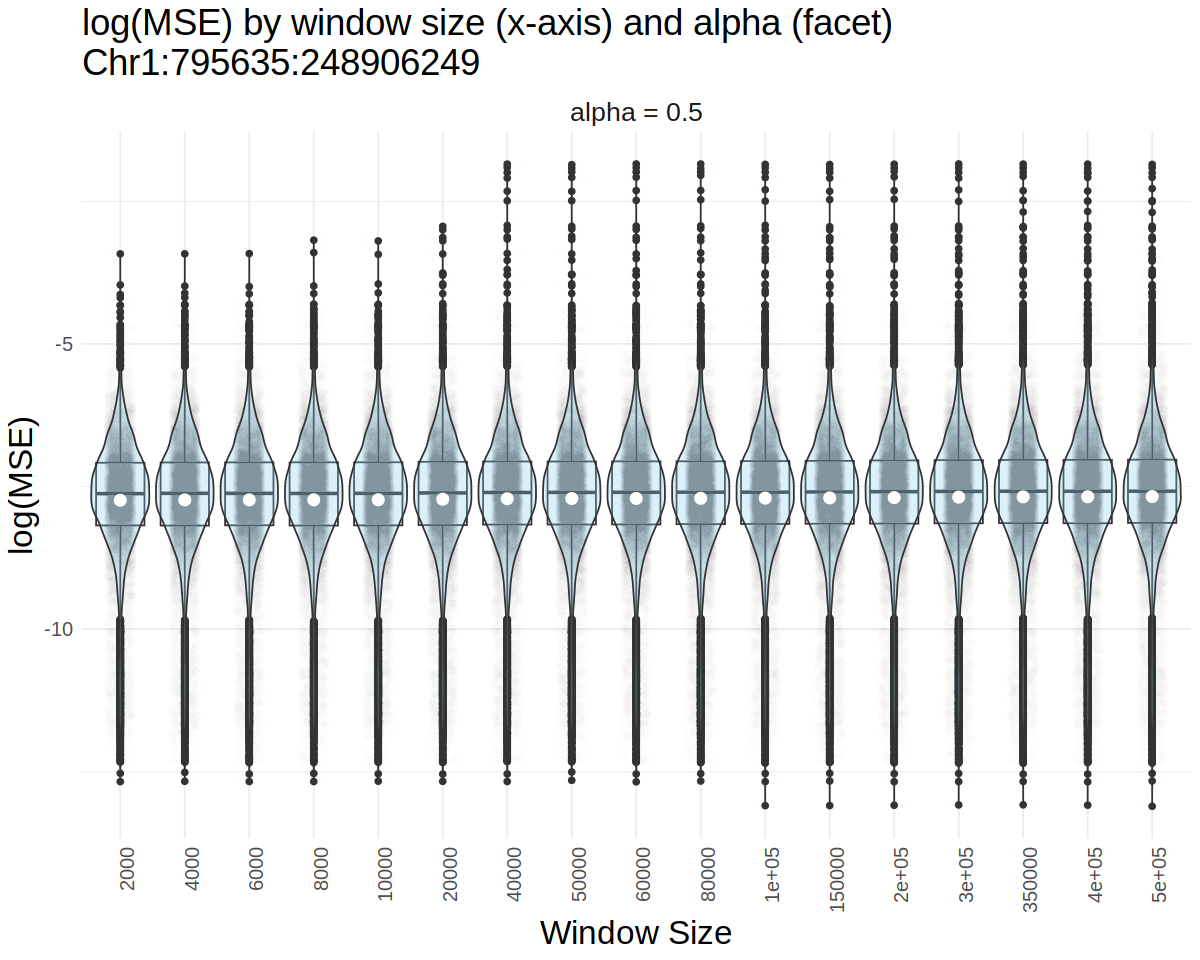

In [35]:
library(dplyr)
library(ggplot2)

df_formatted.2 <- df %>%
  mutate(alpha = factor(alpha, labels = paste("alpha =", levels(factor(alpha)))),
         windowSize = factor(windowSize, labels = paste(levels(factor(windowSize)))))

p_windowSize_formatted <- ggplot(df_formatted.2, aes(x = windowSize, y = cor)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.005) +
  geom_violin(fill = "skyblue", alpha = 0.3) +
  stat_summary(fun = mean, geom = "point", color = "white", shape = 21, size = 3, fill = "white") + # This adds the mean
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("Correlation (R) by window size (x-axis) and alpha (facet)\nChr1:",
                      start_pos, ":", end_pos), x = "Window Size", y = "Correlation (R)") +
  scale_y_continuous(breaks = seq(floor(min(df_formatted.2$cor, na.rm = TRUE)), ceiling(max(df_formatted.2$cor, na.rm = TRUE)), by = 0.1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
    axis.text.y = element_text(size = 12)
  )

#print(p_alpha_formatted)
print(p_windowSize_formatted)

p_windowSize_formatted <- ggplot(df_formatted.2, aes(x = windowSize, y = log(mse))) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.005) +
  geom_violin(fill = "skyblue", alpha = 0.3) +
  stat_summary(fun = mean, geom = "point", color = "white", shape = 21, size = 3, fill = "white") + # This adds the mean
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("log(MSE) by window size (x-axis) and alpha (facet)\nChr1:",
                      start_pos, ":", end_pos), x = "Window Size", y = "log(MSE)") +
  #ylim(0, 0.2) +
  #scale_y_continuous(breaks = seq(floor(min(df_formatted.2$mse, na.rm = TRUE)), ceiling(max(df_formatted.2$cor, na.rm = TRUE)), by = 0.1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
    axis.text.y = element_text(size = 12)
  )

#print(p_alpha_formatted)
print(p_windowSize_formatted)


<div class="alert alert-block alert-info">It appears we can again see a trend of decreasing R with window size. However, as shown above, there's a more complex effect of window size on the percentage of sites for which we're able to compute R. </div>

# Track trends of changes in `alpha`, `window_size` for `cor` of specific given CpG sites

## By plotting

#### Without scaling `cor`

In [36]:
convert_and_order_windowSizes <- function(df, windowSizeColumn = 'windowSize') {
  convert_to_genetic_terms <- function(size) {
    if (size >= 1e6) {
      return(paste0(size / 1e6, "Mb"))
    } else if (size >= 1e3) {
      return(paste0(size / 1e3, "kb"))
    } else {
      return(paste0(size, "bp"))
    }
  }
  
  # Ensure windowSizeColumn is numeric for ordering
  df[[windowSizeColumn]] <- as.numeric(df[[windowSizeColumn]])
  
  # Order the dataframe by the numeric window size
  df <- df[order(df[[windowSizeColumn]]), ]
  
  # Apply the genetic terms conversion
  df$windowSizeLabel <- sapply(df[[windowSizeColumn]], convert_to_genetic_terms)
  
  return(df)
}

# Assuming df's windowSizeColumn is already numeric and properly named 'windowSize'
df <- convert_and_order_windowSizes(df, 'windowSize')


### Statistical models

#### Across all window sizes

##### Effect of window size on R

Let's start with a simple linear model and ANOVA to see if we're able to detect any difference across groups for window size, alpha, and interaction.

In [37]:
model <- lm(cor ~ windowSize,
            data = df)

In [38]:
model


Call:
lm(formula = cor ~ windowSize, data = df)

Coefficients:
(Intercept)   windowSize  
  1.991e-01   -8.172e-08  


In [39]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
windowSize,1,24.51477,24.51477497,394.5243,1.104194e-87
Residuals,154000,9569.18273,0.06213755,NA,NA


<div class="alert alert-block alert-info">Yes, clear effect of window size on R</div>

##### Effect of window size on MSE

In [40]:
model <- lm(mse ~ windowSize,
            data = df)

In [41]:
model


Call:
lm(formula = mse ~ windowSize, data = df)

Coefficients:
(Intercept)   windowSize  
  7.520e-04    4.347e-10  


In [42]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
windowSize,1,0.0007340326,7.340326e-04,81.6239,1.663578e-19
Residuals,161623,1.4534535049,8.992863e-06,NA,NA


<div class="alert alert-block alert-info">Clear effect of window size on MSE detected</div>

#### If we subset to 10 and below

##### Effect of window size on R

In [43]:
subset_df <- df[which(df$windowSize <= 10000), ]

In [44]:
model <- lm(cor ~ windowSize,
            data = subset_df)

In [45]:
model


Call:
lm(formula = cor ~ windowSize, data = subset_df)

Coefficients:
(Intercept)   windowSize  
  2.071e-01   -6.987e-07  


In [46]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
windowSize,1,0.1749055,0.17490548,2.955137,0.08561189
Residuals,45268,2679.2738651,0.05918693,NA,NA


<div class="alert alert-block alert-info">Reducing window size below 10kb, we now detect a less significant relationship between R and window size.</div>

## What's the relationship between SNP effect size and distance from methylation site... and how does this depend on window size?

First, extract all SNP coefficients, IDs, and corresponding methylation sites for our models.<br><br>Let's only make this df for one window size at a time, for fair comparisons.

In [47]:
SNPs_to_df <- function(object) {
  modelsList <- lapply(object@models, function(model) {
    snpIDs <- names(model@snpWeights)
    snpWeights <- model@snpWeights

    expandedModelAttrs <- data.frame(
      scaffoldIdentifier = rep(object@scaffoldIdentifier, length(snpIDs)),
      methylationPosition = rep(model@methylationPosition, length(snpIDs)),
      windowSize = rep(model@windowSize, length(snpIDs)),
      SNP_ID = snpIDs,
      SNP_Weight = snpWeights,
      cor = rep(model@evaluation_results[['cor']], length(snpIDs))
    )

    return(expandedModelAttrs)
  })

  df <- do.call("rbind", modelsList)
  
  df <- convert_and_order_windowSizes(df, 'windowSize')
  
  return(df)
}

In [48]:
snp_df <- data.frame()

In [49]:
for(scaff_path in scaff_paths){
    my_scaff <- readRDS(scaff_path)
    small_snp_df <- SNPs_to_df(my_scaff)
    snp_df <- bind_rows(snp_df, small_snp_df)
}

In [50]:
snp_df$SNP_Position <- as.numeric(gsub(".*:(\\d+):.*", "\\1", snp_df$SNP_ID))
snp_df$Distance = abs(snp_df$methylationPosition - snp_df$SNP_Position)


In [51]:
dim(snp_df)

[1] 568049      9

In [52]:
r_squared_df <- snp_df %>%
  group_by(windowSize) %>%
  do({
    model <- lm(cor ~ Distance, data = .)
    data.frame(R2 = summary(model)$r.squared)
  }) %>%
  ungroup() %>%
  mutate(windowSize = as.factor(windowSize))

print(r_squared_df)


# A tibble: 17 × 2
   windowSize      R2
   <fct>        <dbl>
 1 2000       0.00750
 2 4000       0.0109 
 3 6000       0.0180 
 4 8000       0.0195 
 5 10000      0.0174 
 6 20000      0.0329 
 7 40000      0.0440 
 8 50000      0.0506 
 9 60000      0.0563 
10 80000      0.0627 
11 1e+05      0.0639 
12 150000     0.0836 
13 2e+05      0.0938 
14 3e+05      0.113  
15 350000     0.122  
16 4e+05      0.123  
17 5e+05      0.121  


<div class="alert alert-block alert-info">Very weak correlation between distance from methylation site and SNP effect size is surprising</div>

In [53]:
# library(ggplot2)

# ggplot(snp_df, aes(x = Distance, y = SNP_Weight, color = as.factor(windowSize))) +
#   geom_point(alpha = 0.1) +
#   #geom_smooth(method = "lm", se = FALSE, size = 2) + # Add trendline
#   labs(title = "SNP effect size vs. distance by window size",
#        x = "Distance between SNP and methylation site",
#        y = "SNP effect size") +  
#   theme(legend.position = "none",
#         text = element_text(size = 20),
#         plot.title = element_text(size = 22),
#         axis.title = element_text(size = 20),
#         axis.text.x = element_text(size = 14),
#         axis.text.y = element_text(size = 14))

<div class="alert alert-block alert-info">We have some extreme outliers on the lower end for some reason</div>

In [54]:
# library(ggplot2)

# ggplot(snp_df, aes(x = Distance, y = SNP_Weight, color = as.factor(windowSize))) +
#   geom_point(alpha = 0.2) +
#   #geom_smooth(method = "lm", se = FALSE, size = 2) + # Add trendline
#   labs(title = "SNP effect size vs. distance by window size (y-truncated)",
#        x = "Distance between SNP and methylation site",
#        y = "SNP effect size") +  
#   ylim(-0.1, 0.1)+
#   theme(text = element_text(size = 20),
#         plot.title = element_text(size = 22),
#         axis.title = element_text(size = 20),
#         axis.text.x = element_text(size = 14),
#         axis.text.y = element_text(size = 14))

Does this trend hold up if we only look at large windows?

In [55]:
# library(ggplot2)

# snp_df_subset <- snp_df[which(snp_df$windowSize >= 500000), ]

# ggplot(snp_df_subset, aes(x = Distance, y = SNP_Weight, color = as.factor(windowSize))) +
#   geom_point(alpha = 0.2) +
#   #geom_smooth(method = "lm", se = FALSE, size = 2) + # Add trendline
#   labs(title = "SNP effect size vs. distance by window size (y-truncated)",
#        x = "Distance between SNP and methylation site",
#        y = "SNP effect size") +  
#   ylim(-0.25, 0.025)+
#   theme(text = element_text(size = 20),
#         plot.title = element_text(size = 22),
#         axis.title = element_text(size = 20),
#         axis.text.x = element_text(size = 14),
#         axis.text.y = element_text(size = 14))

## When window size varies, how similar is correlation for given SNPs

<div class="alert alert-block alert-info">In these plots, each dot represents a SNP included in runs for both window sizes, with cor for each window size shown on a different axis.</div>

In [56]:
levels(factor(snp_df$windowSize))

[1] "2000"   "4000"   "6000"   "8000"   "10000"  "20000"  "40000"  "50000" 
 [9] "60000"  "80000"  "1e+05"  "150000" "2e+05"  "3e+05"  "350000" "4e+05" 
[17] "5e+05"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


R^2: 0.5049602 


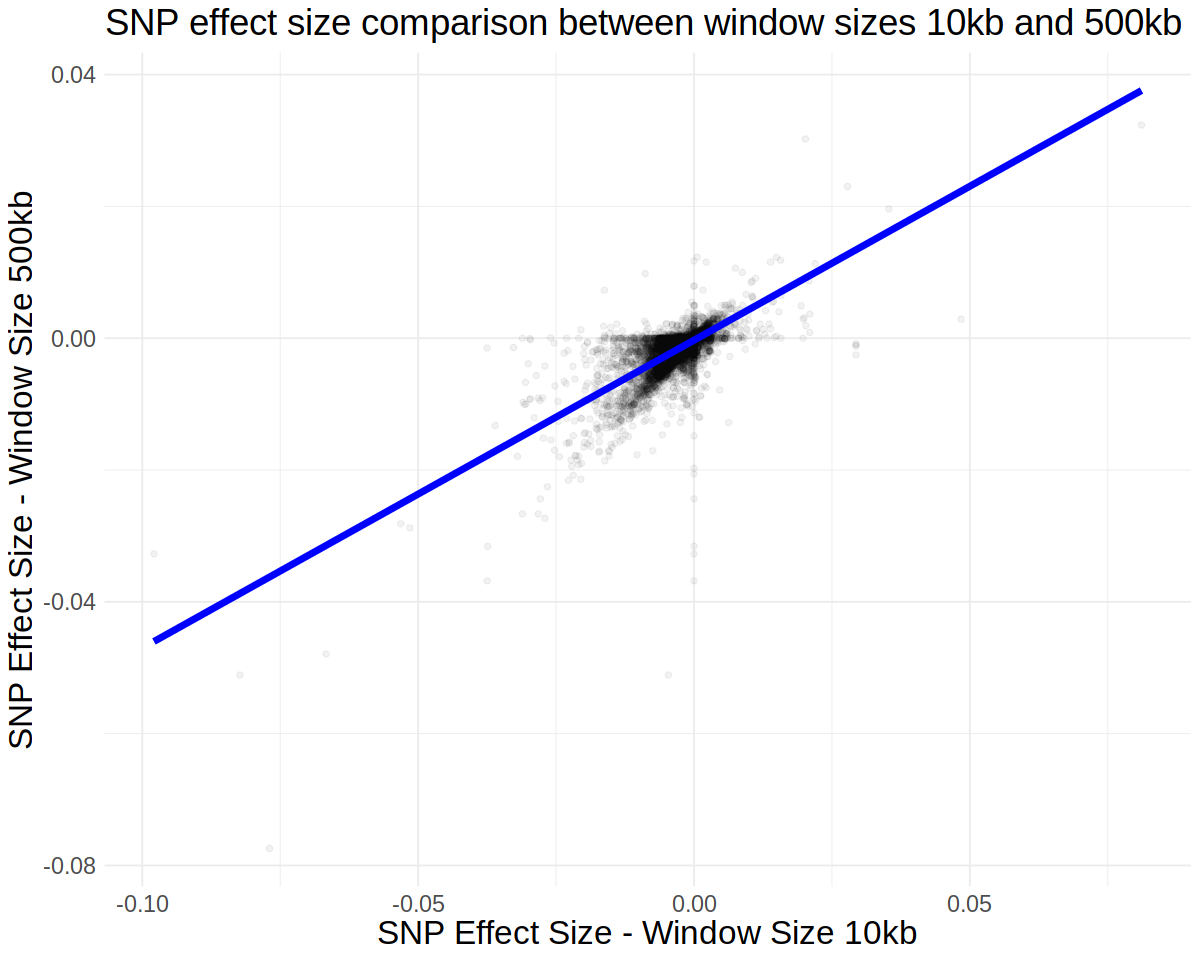

In [57]:
plotSNPEffectSizes <- function(data, labelX, labelY) {
  # Filter for SNPs present in both specified window size labels
  dataX <- subset(data, windowSizeLabel == labelX)
  dataY <- subset(data, windowSizeLabel == labelY)
  
  # Find common SNPs in both window size labels
  commonSNPIDs <- intersect(dataX$SNP_ID, dataY$SNP_ID)
  
  # Subset data for common SNPs
  dataXCommon <- subset(dataX, SNP_ID %in% commonSNPIDs)
  dataYCommon <- subset(dataY, SNP_ID %in% commonSNPIDs)
  
  commonSNPs <- merge(dataXCommon, dataYCommon, by = "SNP_ID", suffixes = c("_x", "_y"))
  
  plot <- ggplot(commonSNPs, aes(x = SNP_Weight_x, y = SNP_Weight_y)) +
    geom_point(alpha = 0.05) +
    geom_smooth(method = "lm", se = FALSE, color = "blue", size = 2) +
    labs(title = paste("SNP effect size comparison between window sizes", labelX, "and", labelY),
         x = paste("SNP Effect Size - Window Size", labelX),
         y = paste("SNP Effect Size - Window Size", labelY)) +
    theme_minimal() +
    theme(legend.position = "none",
          text = element_text(size = 20),
          plot.title = element_text(size = 22),
          axis.title = element_text(size = 20),
          axis.text.x = element_text(size = 14),
          axis.text.y = element_text(size = 14))
  
  print(plot)
  
  # Calculate and print R^2 for linear model of SNP_Weight comparison
  model <- lm(SNP_Weight_y ~ SNP_Weight_x, data = commonSNPs)
  rSquared <- summary(model)$r.squared
  cat("R^2:", rSquared, "\n")
}

plotSNPEffectSizes(snp_df, "10kb", "500kb")


<div class="alert alert-block alert-info">Weak agreement when window sizes are very different</div>

In [58]:
levels(factor(snp_df$windowSize))

[1] "2000"   "4000"   "6000"   "8000"   "10000"  "20000"  "40000"  "50000" 
 [9] "60000"  "80000"  "1e+05"  "150000" "2e+05"  "3e+05"  "350000" "4e+05" 
[17] "5e+05"

`geom_smooth()` using formula = 'y ~ x'


R^2: 0.6781825 


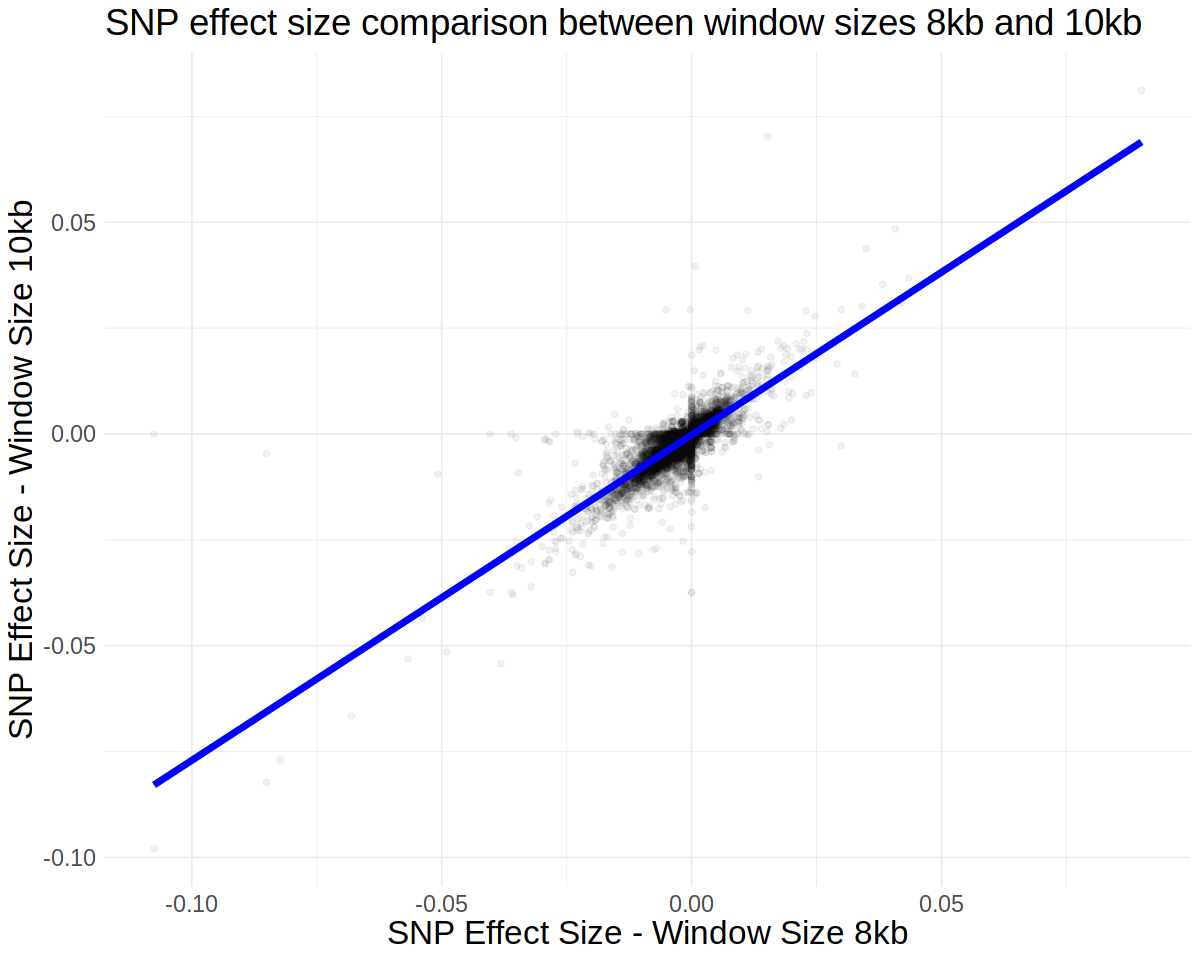

In [59]:
plotSNPEffectSizes(snp_df, "8kb", "10kb")

<div class="alert alert-block alert-info">Agreement is not always stronger when window sizes are closer</div>

## How frequently does each possible window size give best performance for given methylation site?

### Performance according to R

In [60]:
dim(df)[1]/length(levels(factor(df$windowSize)))

[1] 9507.353

In [61]:
colnames(df)

[1] "scaffoldIdentifier"  "methylationPosition" "windowSize"         
[4] "nSNPs"               "cor"                 "mse"                
[7] "alpha"               "lambda"              "windowSizeLabel"

In [62]:
frequency_of_max_cor <- table(df$windowSize[ave(df$cor, df$methylationPosition, FUN = function(x) seq_along(x) == which.max(x)) == 1])


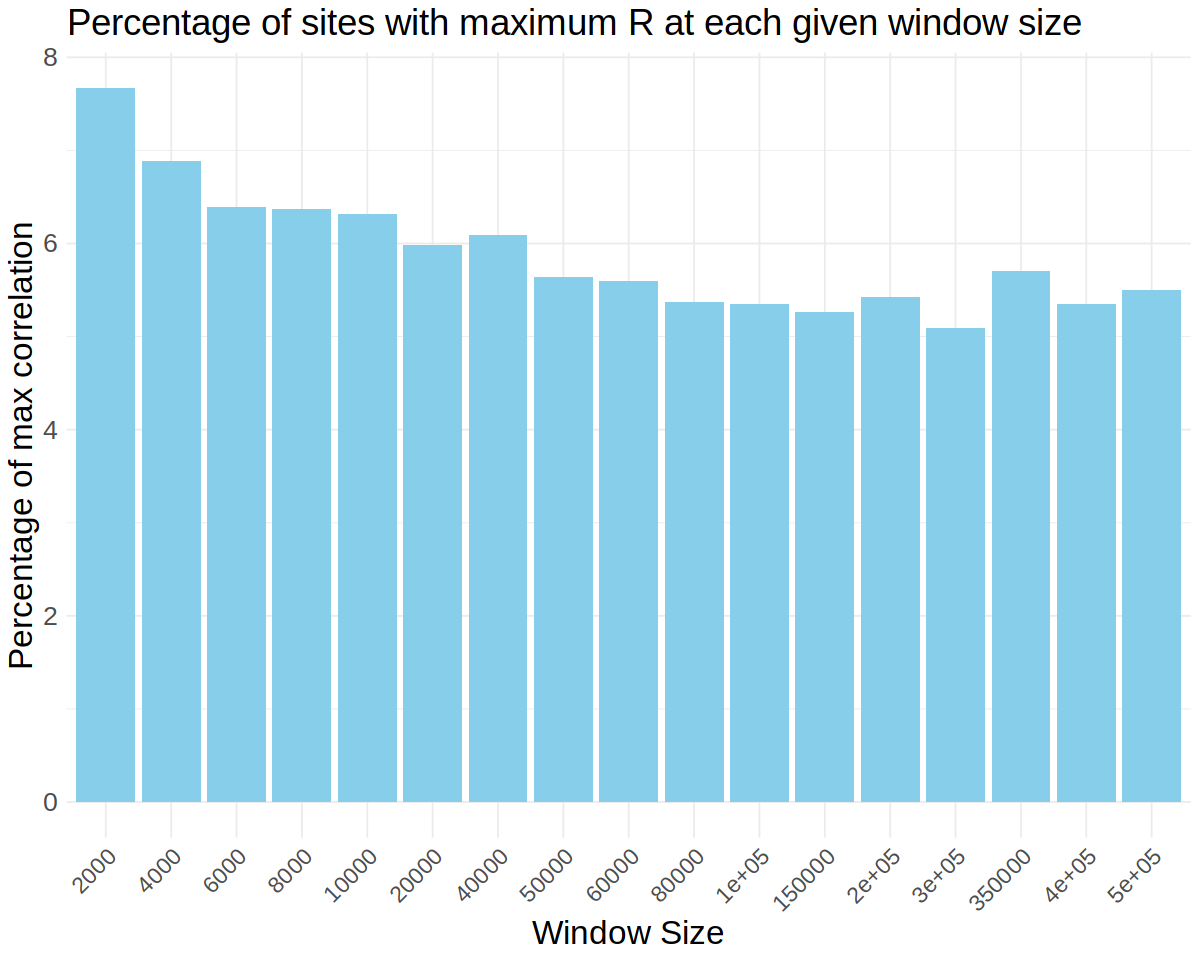

In [63]:
percentage_of_max_cor <- prop.table(frequency_of_max_cor) * 100

percentage_df <- data.frame(
  windowSize = names(percentage_of_max_cor),
  percentage = as.numeric(percentage_of_max_cor)
)

percentage_df$windowSize_numeric <- as.numeric(gsub("kb", "", percentage_df$windowSize))
percentage_df <- percentage_df[order(percentage_df$windowSize_numeric),]

library(ggplot2)
ggplot(percentage_df, aes(x = reorder(windowSize, windowSize_numeric), y = percentage)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  theme_minimal() +
  labs(title = "Percentage of sites with maximum R at each given window size",
       x = "Window Size", 
       y = "Percentage of max correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14)
  )


### Performance according to MSE

In [64]:
frequency_of_max_mse <- table(df$windowSize[ave(df$mse, df$methylationPosition, FUN = function(x) seq_along(x) == which.min(x)) == 1])


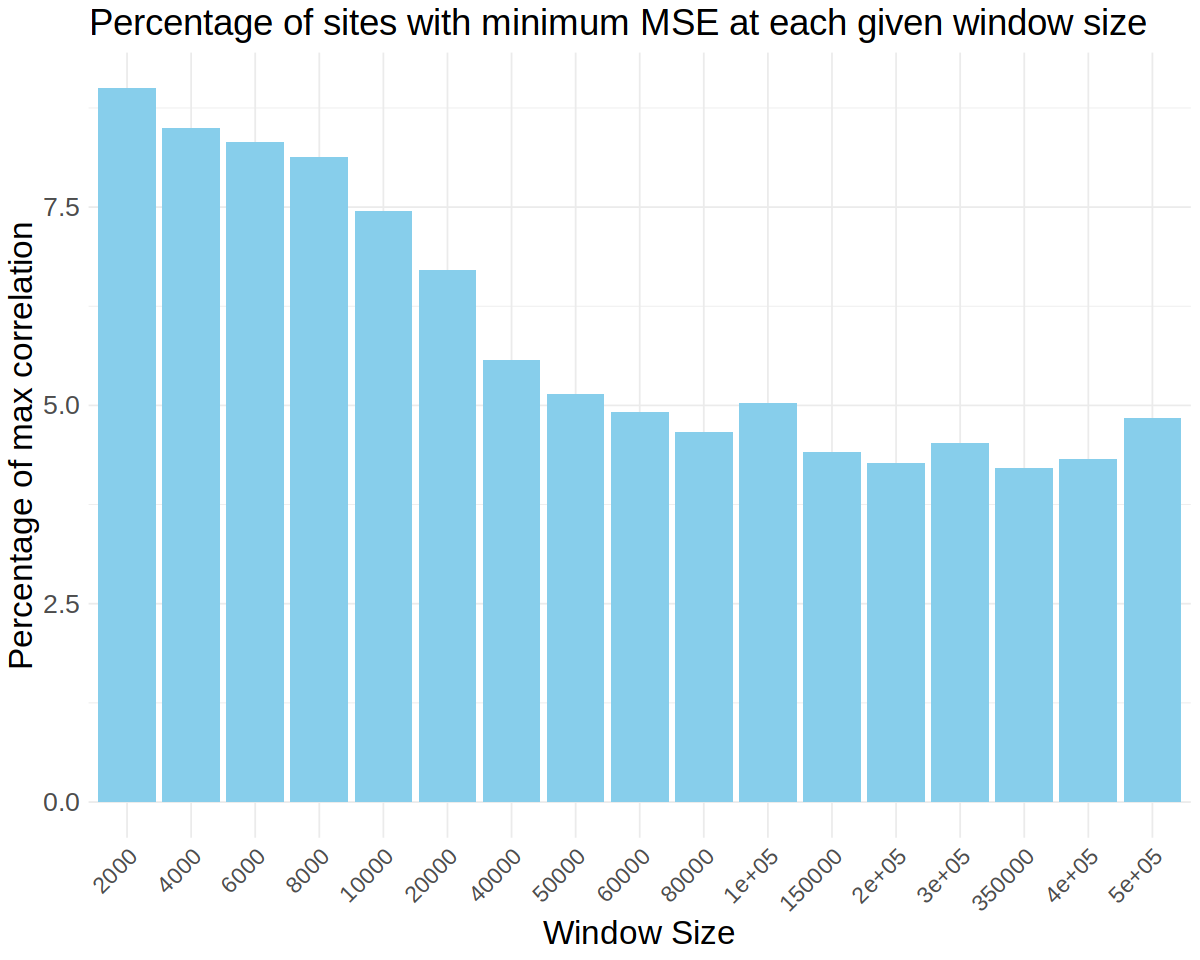

In [65]:
percentage_of_max_mse <- prop.table(frequency_of_max_mse) * 100

percentage_df <- data.frame(
  windowSize = names(percentage_of_max_mse),
  percentage = as.numeric(percentage_of_max_mse)
)

percentage_df$windowSize_numeric <- as.numeric(gsub("kb", "", percentage_df$windowSize))
percentage_df <- percentage_df[order(percentage_df$windowSize_numeric),]

library(ggplot2)
ggplot(percentage_df, aes(x = reorder(windowSize, windowSize_numeric), y = percentage)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  theme_minimal() +
  labs(title = "Percentage of sites with minimum MSE at each given window size",
       x = "Window Size", 
       y = "Percentage of max correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14)
  )


## GGpairs plot

In [66]:
head(df)

,scaffoldIdentifier,methylationPosition,windowSize,nSNPs,cor,mse,alpha,lambda,windowSizeLabel
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
cor...1,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,2000,14,0.42066469,7.567610e-04,0.5,0.014482555,2kb
cor17...18,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,40450399,2000,15,0.02294457,3.189707e-05,0.5,0.001315012,2kb
cor34...35,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,106855312,2000,2,0.13487565,1.105703e-03,0.5,0.015504254,2kb
cor51...52,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,24538561,2000,13,0.28402721,1.067592e-03,0.5,0.011997065,2kb
cor68...69,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,184974528,2000,9,-0.25537627,1.345090e-04,0.5,0.001730309,2kb
cor85...86,libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,192383468,2000,14,0.61864888,9.100181e-04,0.5,0.017589261,2kb


In [67]:
library(GGally)
library(dplyr)
library(tidyr)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




In [68]:
dim(df)

[1] 161625      9

In [69]:
df <- df[which(df$alpha == 0.5), ]

In [70]:
dim(df)

[1] 161625      9

In [71]:
df_subset <- df[df$windowSizeLabel %in% c('2kb', "6kb", "10kb", "40kb", "80kb", "150kb", "300kb", "500kb"), ]

In [72]:
length(levels(factor(df$methylationPosition)))

[1] 9769

In [73]:
library(data.table)
setDT(df)[, dcast(.SD, scaffoldIdentifier + methylationPosition + windowSize + nSNPs + cor + mse + alpha + lambda ~ windowSizeLabel, value.var = "windowSizeLabel")]


Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last




scaffoldIdentifier,methylationPosition,windowSize,nSNPs,cor,mse,alpha,lambda,100kb,10kb,⋯,350kb,400kb,40kb,4kb,500kb,50kb,60kb,6kb,80kb,8kb
<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,100000,11,0.12829379,0.0007645531,0.5,0.008662155,100kb,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,150000,129,0.13036082,0.0007752309,0.5,0.008662155,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,200000,129,-0.07573850,0.0007803751,0.5,0.008662155,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,300000,298,-0.18199673,0.0007762645,0.5,0.008662155,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,350000,300,-0.08792877,0.0007713892,0.5,0.008662155,NA,NA,⋯,350kb,NA,NA,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,400000,303,0.07793454,0.0007638932,0.5,0.008662155,NA,NA,⋯,NA,400kb,NA,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,983231,500000,312,-0.06294599,0.0007669019,0.5,0.008662155,NA,NA,⋯,NA,NA,NA,NA,500kb,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,1050168,40000,18,0.29093790,0.0001795973,0.5,0.008119648,NA,NA,⋯,NA,NA,40kb,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,1050168,50000,35,0.24206802,0.0001794747,0.5,0.008119648,NA,NA,⋯,NA,NA,NA,NA,NA,50kb,NA,NA,NA,NA


In [74]:
df_wide <- df_subset %>%
  unite("position_window", windowSizeLabel, remove = FALSE) %>%
  pivot_wider(names_from = "position_window", values_from = cor)

# Prepare the data for ggpairs: select only the new cor columns
df_for_ggpairs <- select(df_wide, starts_with("cor"))


In [75]:
head(df_wide)

scaffoldIdentifier,methylationPosition,windowSize,nSNPs,mse,alpha,lambda,windowSizeLabel,2kb,6kb,10kb,40kb,80kb,150kb,300kb,500kb
<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,2000,14,7.567610e-04,0.5,0.014482555,2kb,0.42066469,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,40450399,2000,15,3.189707e-05,0.5,0.001315012,2kb,0.02294457,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,106855312,2000,2,1.105703e-03,0.5,0.015504254,2kb,0.13487565,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,24538561,2000,13,1.067592e-03,0.5,0.011997065,2kb,0.28402721,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,184974528,2000,9,1.345090e-04,0.5,0.001730309,2kb,-0.25537627,NA,NA,NA,NA,NA,NA,NA
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,192383468,2000,14,9.100181e-04,0.5,0.017589261,2kb,0.61864888,NA,NA,NA,NA,NA,NA,NA


Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning mess

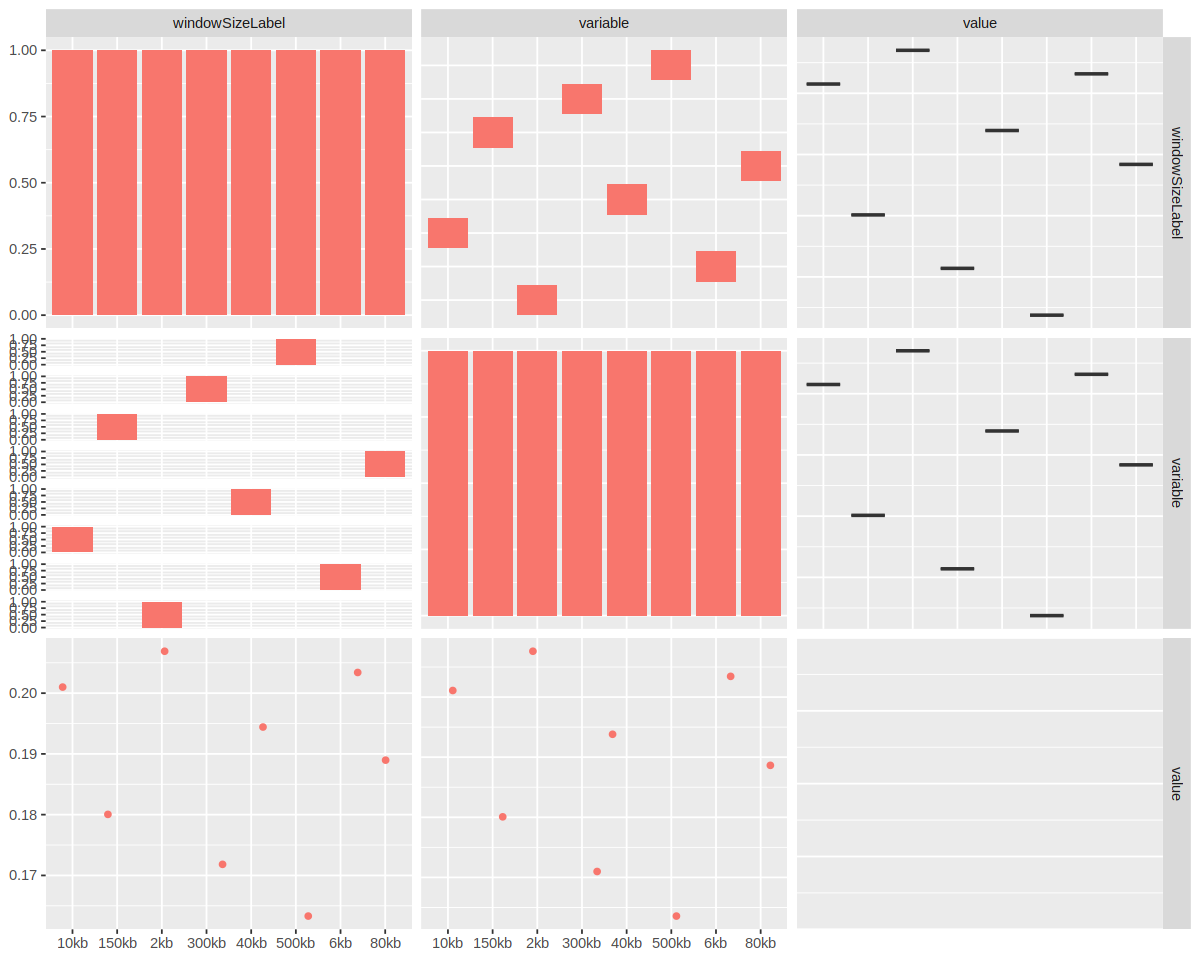

In [76]:
library(GGally)
library(dplyr)

# Create a summarized version of your data for "cor" by "windowSizeLabel"
df_summarized <- df_subset %>%
  group_by(windowSizeLabel) %>%
  summarise(cor_mean = mean(cor, na.rm = TRUE))

# Create a long format data frame suitable for ggpairs
df_long <- pivot_longer(df_summarized, cols = cor_mean, names_to = "variable", values_to = "value")

# Plot using ggpairs
ggpairs(df_long, aes(x = windowSizeLabel, y = value, color = variable),
        upper = list(continuous = "density", combo = "box_no_facet"),
        lower = list(continuous = "points", combo = "dot_no_facet"))


In [77]:
head(df)

scaffoldIdentifier,methylationPosition,windowSize,nSNPs,cor,mse,alpha,lambda,windowSizeLabel
<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,2367119,2000,14,0.42066469,7.567610e-04,0.5,0.014482555,2kb
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,40450399,2000,15,0.02294457,3.189707e-05,0.5,0.001315012,2kb
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,106855312,2000,2,0.13487565,1.105703e-03,0.5,0.015504254,2kb
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,24538561,2000,13,0.28402721,1.067592e-03,0.5,0.011997065,2kb
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,184974528,2000,9,-0.25537627,1.345090e-04,0.5,0.001730309,2kb
libd_chr1-chr1_all-libd_chr1-chr1_all-1-200-dynamic-1corestotal-1corepera-20240319-124236,192383468,2000,14,0.61864888,9.100181e-04,0.5,0.017589261,2kb


In [ ]:
# Assuming your data frame is named df

# First, spread the data so each windowSizeLabel has its own column for "cor" values
df_spread <- df %>%
  select(cor, windowSizeLabel) %>%
  spread(key = windowSizeLabel, value = cor)

# Use ggpairs to plot the comparisons
ggpairs(df_spread)